In [1]:
import pandas as pd
import numpy as np
import os
import time
import sys
import scanpy as sc
import scipy
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import gget

import celltypist
from celltypist import models

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/clean_data/"

data = {}

for f in os.listdir(dirpath):
    if "cpm" in f:
        fullpath = f"{dirpath}{f}"
        key = f.split("_cpm")[0]
        df = pd.read_parquet(fullpath)
        print(f"{key} {df.shape=}")

        # store the barcodes
        idf = pd.DataFrame(df.index.tolist(), columns=['barcode'])
        idf['key'] = key

        # rename index
        df = df.reset_index(drop=True)
        df.index = f"{key}_" + df.index.astype(str)

        # add new names
        idf['cellId'] = df.index.to_list()

        data[key] = df

## combine data!
df = [v for v in data.values()]

df = pd.concat(df)
print(f"{df.shape=}")
df = df.fillna(0)

print('done!')

fed_f df.shape=(11290, 22047)
fasted_m df.shape=(10227, 22211)
fed_m df.shape=(9249, 21851)
fasted_f df.shape=(12171, 22861)
df.shape=(42937, 23366)
done!


In [10]:
""" Load clustering """
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/cluster_results.csv"
cdf = pd.read_csv(fpath)
print(f"{cdf.shape=}")
# cdf.head()

""" Load enrichments """
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/cluster_enrichment_results.csv"
edf = pd.read_csv(fpath)

# add grouped ranks
edf['rank'] = edf.groupby(['cluster'])['adj_p_val'].transform('rank')

print(f"{edf.shape=}")
edf.head()

cdf.shape=(42937, 8)
edf.shape=(829, 5)


,path_name,adj_p_val,overlapping_genes,cluster,rank
0,Oligodendrocytes,1.567567e-37,"['TMEM63A', 'MYRF', 'HEPACAM', 'FAM107A', 'ITP...",1.0,1.0
1,Schwann Cells,6.466438e-16,"['ZCCHC24', 'PHLDB1', 'CNP', 'MEGF10', 'CMTM5'...",1.0,2.0
2,Astrocytes,5.364503e-15,"['ITIH3', 'KCNJ10', 'OPALIN', 'CMTM5', 'FAM107...",1.0,3.0
3,M?ller Cells,2.914255e-10,"['IL33', 'SPARC', 'KCNJ10', 'MEGF10', 'FAM107A...",1.0,4.0
4,Bergmann Glia,3.938986e-10,"['ITIH3', 'KCNJ10', 'HEPACAM', 'OPALIN', 'FAM1...",1.0,5.0


path_name
Schwann Cells                     12123
Bergmann Glia                      9028
Astrocytes                         4409
Interneurons                       2481
Enteric Neurons                    1699
Oligodendrocytes                   1472
Glutaminergic Neurons              1322
M?ller Cells                       1220
Neurons                            1182
Taste Receptor Cells                897
Retinal Ganglion Cells              897
Immature Neurons                    505
Gamma (PP) Cells                    474
Pyramidal Cells                     470
Photoreceptor Cells                 394
Anterior Pituitary Gland Cells       67
Name: count, dtype: int64


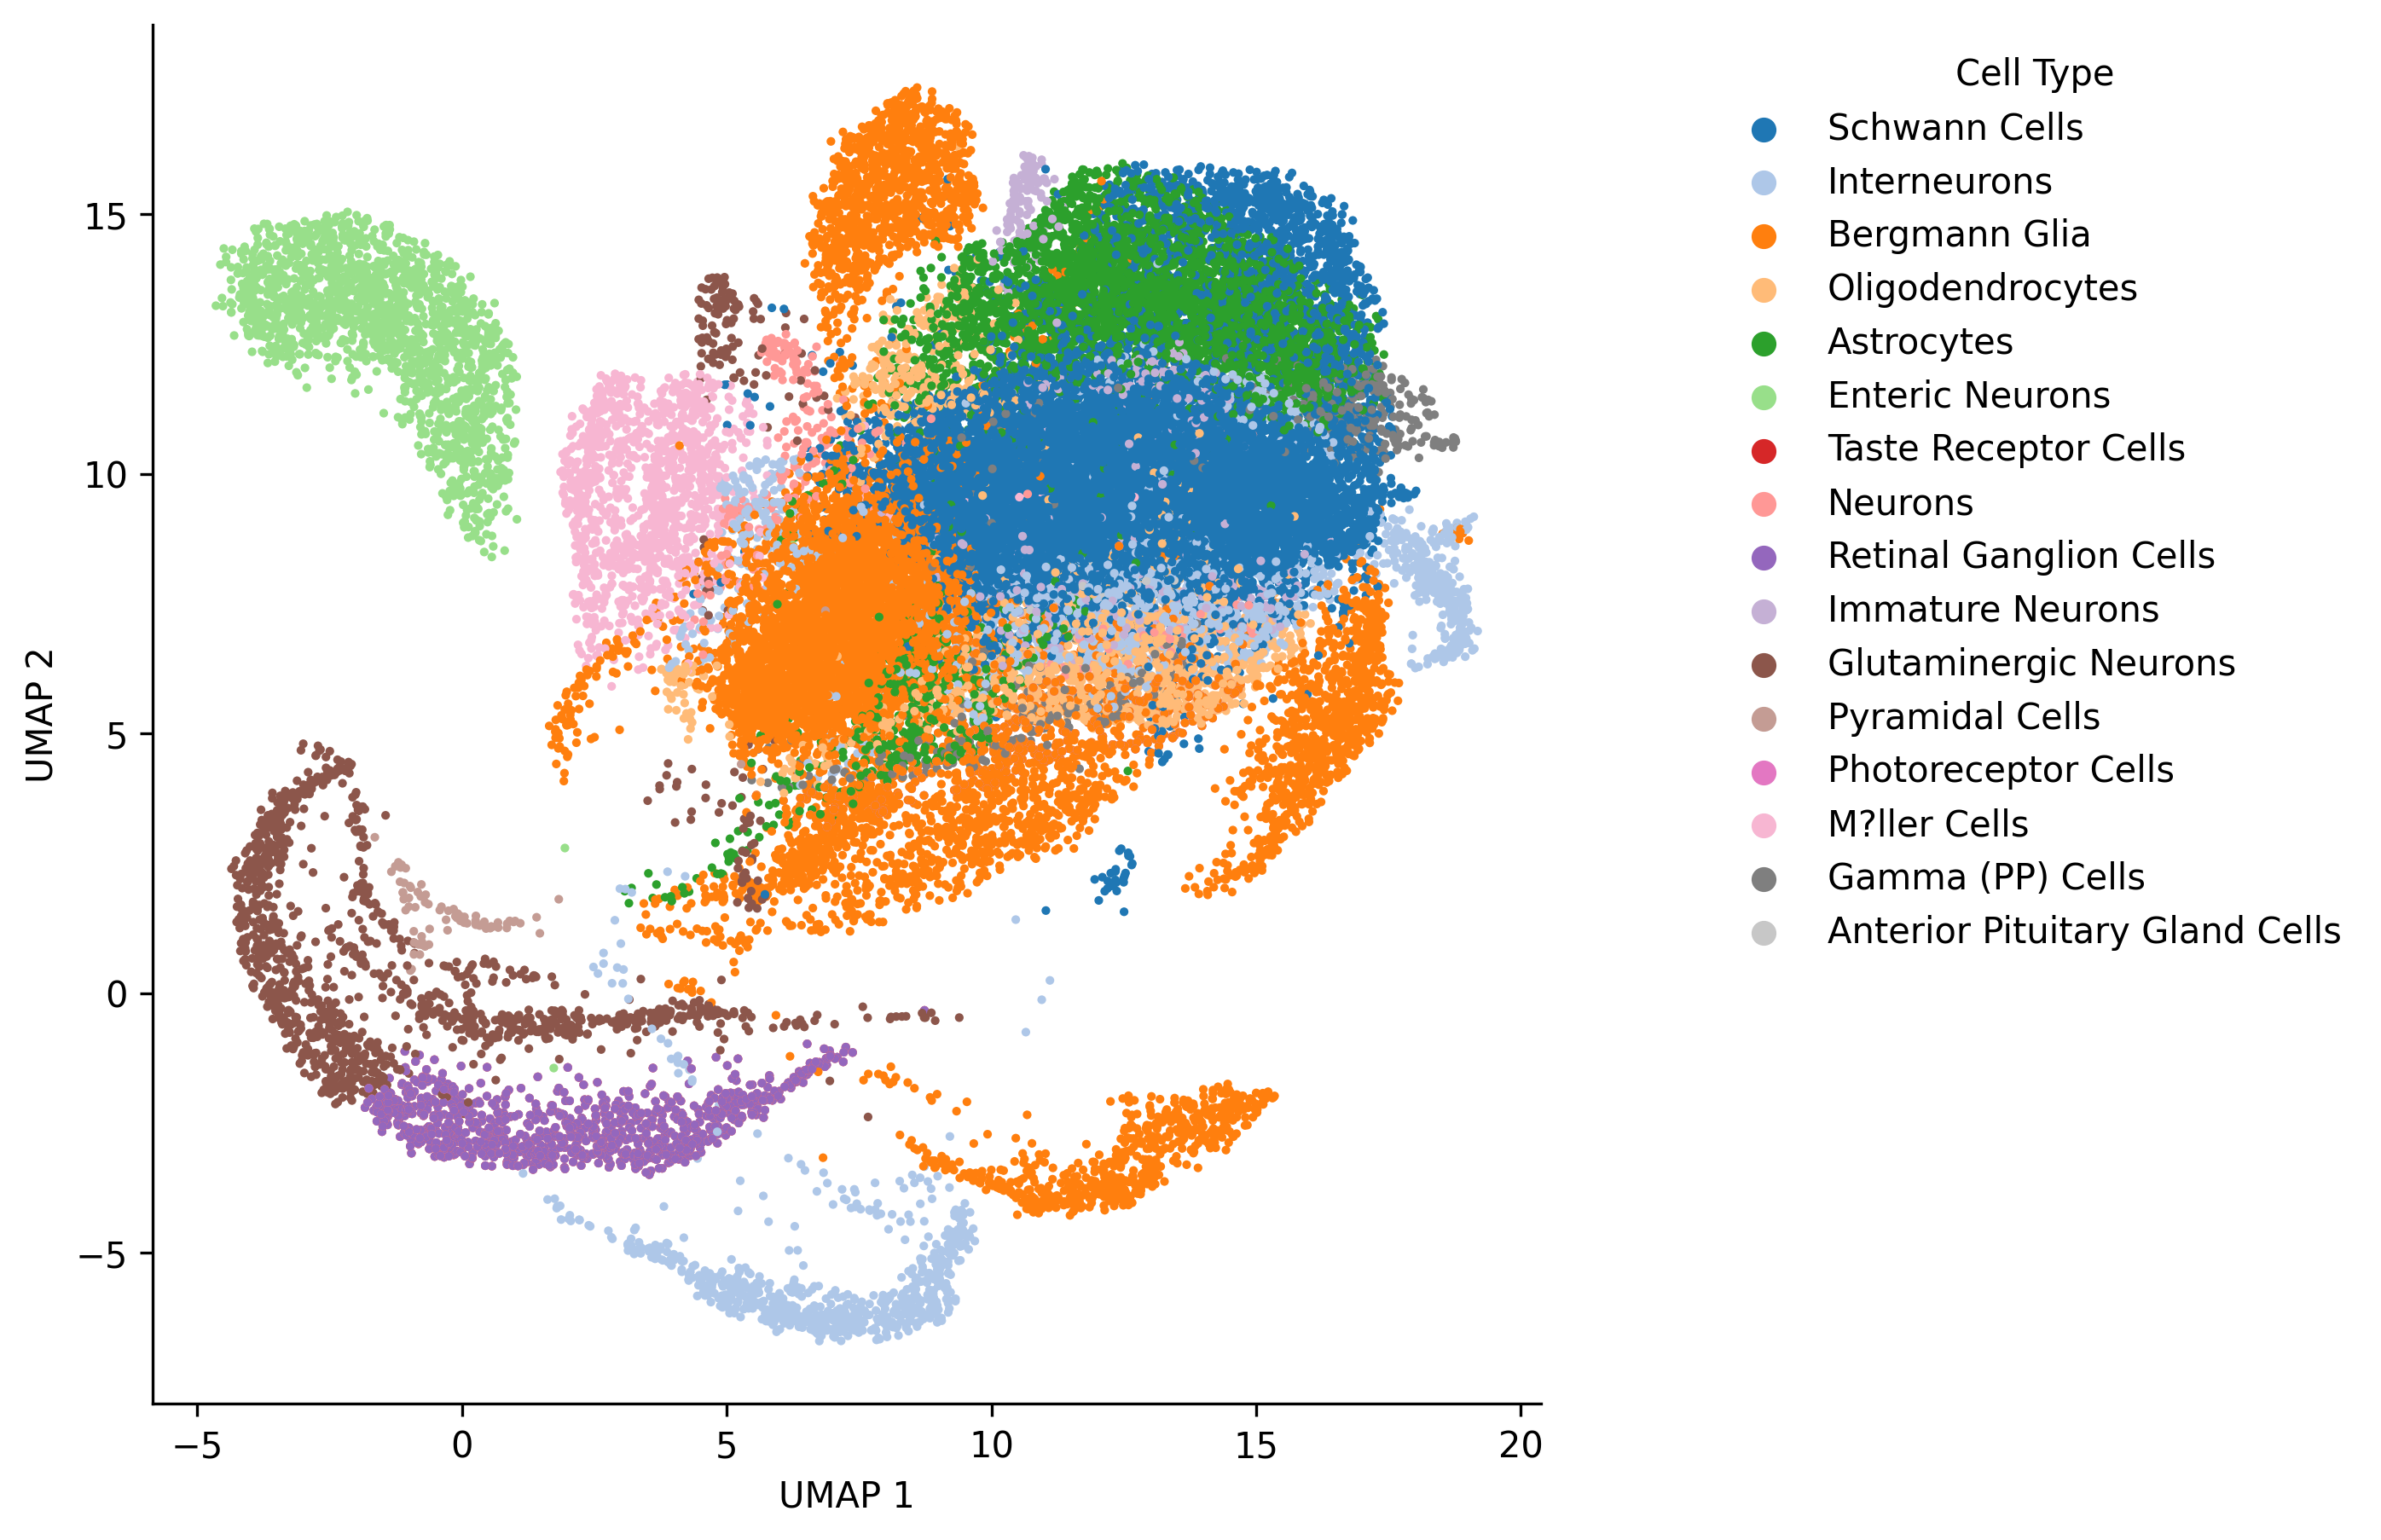

In [33]:
rank = 2

pdf = cdf.copy()

pdf = pd.merge(pdf, edf[edf['rank'] == rank],
              how='left',
              left_on='cluster',
              right_on='cluster',)



print(pdf['path_name'].value_counts())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.scatterplot(data=pdf, 
                x='UMAP 1',
                y='UMAP 2',
                s=6,
                hue='path_name',
                palette='tab20',
                ec='none')

sns.despine()
sns.move_legend(plt.gca(), 
                title='Cell Type',
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.6, 1))

# pdf.head()


In [17]:
pdf.head()

,UMAP 1,UMAP 2,cluster,barcode,key,cellId,diet,sex,path_name,adj_p_val,overlapping_genes,rank
0,12.023250,9.483123,1.0,AAACCCAGTACAGCGA-1,fasted_f,fasted_f_0,fasted,f,Schwann Cells,6.466438e-16,"['ZCCHC24', 'PHLDB1', 'CNP', 'MEGF10', 'CMTM5'...",2.0
1,17.551298,8.710315,28.0,AAACCCAGTACCAGAG-1,fasted_f,fasted_f_1,fasted,f,Interneurons,1.204893e-12,"['PCSK2', 'NRN1', 'KCNA2', 'RORB', 'ADCY8', 'T...",2.0
2,12.718518,11.699971,29.0,AAACGAAAGTGAGCCA-1,fasted_f,fasted_f_10,fasted,f,NaN,NaN,NaN,NaN
3,7.088437,3.514980,7.0,AAAGGTATCAGGTAAA-1,fasted_f,fasted_f_100,fasted,f,Bergmann Glia,9.205239e-10,"['RBFOX1', 'SPHKAP', 'HEPACAM', 'CADM2', 'OPAL...",2.0
4,7.368012,12.797168,7.0,ACGATCACAGGTTCGC-1,fasted_f,fasted_f_1000,fasted,f,Bergmann Glia,9.205239e-10,"['RBFOX1', 'SPHKAP', 'HEPACAM', 'CADM2', 'OPAL...",2.0


In [35]:
?gget.enrichr

Signature:
gget.enrichr(
    genes,
    database,
    ensembl=False,
    plot=False,
    figsize=(10, 10),
    ax=None,
    json=False,
    save=False,
)
Docstring:
Perform an enrichment analysis on a list of genes using Enrichr (https://maayanlab.cloud/Enrichr/).

Args:
- genes       List of Entrez gene symbols to perform enrichment analysis on, passed as a list of strings, e.g. ['PHF14', 'RBM3', 'MSL1', 'PHF21A'].
              Set 'ensembl = True' to input a list of Ensembl gene IDs, e.g. ['ENSG00000106443', 'ENSG00000102317', 'ENSG00000188895'].
- database    Database to use as reference for the enrichment analysis.
              Supported shortcuts (and their default database):
              'pathway' (KEGG_2021_Human)
              'transcription' (ChEA_2016)
              'ontology' (GO_Biological_Process_2021)
              'diseases_drugs' (GWAS_Catalog_2019)
              'celltypes' (PanglaoDB_Augmented_2021)
              'kinase_interactions' (KEA_2015)
              or an